In [ ]:
import os
import cv2
import zipfile
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DRIVE_ZIP_PATH = "/content/drive/MyDrive/dataset corrosao.v1i.png-mask-semantic.zip"
WORK_DIR = "/content/corrosion_project"
os.makedirs(WORK_DIR, exist_ok=True)
print("Unzipping... (this may take a while if large)")
with zipfile.ZipFile(DRIVE_ZIP_PATH, 'r') as z:
    z.extractall(WORK_DIR)
print("Unzipped to", WORK_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Unzipping... (this may take a while if large)
Unzipped to /content/corrosion_project


In [ ]:
BASE_DIR = "/content/corrosion_project"
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "train")
VAL_IMG_DIR = os.path.join(BASE_DIR, "valid")
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [ ]:
def enhance(image):
    # Convert to float and normalize
    image = image.astype(np.float32) / 255.0
    # Sharpen edges by subtracting a blurred version from the original
    blur = cv2.GaussianBlur(image, (5, 5), 0)
    enhanced = cv2.addWeighted(image, 1.5, blur, -0.5, 0)
    # Clip values to [0, 1] range and convert back to uint8
    enhanced = np.clip(enhanced, 0, 1)
    return (enhanced * 255).astype(np.uint8)

In [ ]:
class CorrosionDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.images = sorted(glob(os.path.join(img_dir, "*.jpg")))
        self.masks = [p.replace(".jpg", "_mask.png") for p in self.images]
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx]
        # Load and enhance the image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = enhance(image)
        # Load the mask as grayscale
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Could not read mask at {mask_path}")
        # Normalize mask to [0, 1]
        mask = mask.astype(np.float32)
        mask /= mask.max() if mask.max() > 0 else 1.0
        # Resize both image and mask
        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256))
        # Convert to tensors
        image = torch.tensor(image.transpose(2, 0, 1) / 255., dtype=torch.float32)
        # Add a channel dimension to the mask [H, W] -> [1, H, W]
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        return image, mask

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        # Encoder
        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2, 2)
        # Bridge
        self.bridge = CBR(512, 1024)
        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        # Final output layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)
    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        # Bridge
        b = self.bridge(self.pool(e4))
        # Decoder path
        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        out = torch.sigmoid(self.final(d1))
        return out

In [ ]:
# Create datasets and dataloaders
train_ds = CorrosionDataset(TRAIN_IMG_DIR)
val_ds = CorrosionDataset(VAL_IMG_DIR)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=False)
# Initialize model, loss, and optimizer
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 15

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_pixels = 0
    progress_bar = tqdm(train_dl, desc=f'Epoch {epoch+1}/{num_epochs}')
    for imgs, masks in progress_bar:
        imgs, masks = imgs.to(device), masks.to(device)
        # Forward pass
        preds = model(imgs)
        loss = criterion(preds, masks)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # Calculate pixel-wise accuracy
        predicted_masks = (preds > 0.5).float()
        total_correct += (predicted_masks == masks).sum().item()
        total_pixels += masks.numel()
    avg_loss = total_loss / len(train_dl)
    accuracy = total_correct / total_pixels
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}")
# Save the trained model
MODEL_SAVE_PATH = "/content/corrosion_unet_enhanced.pth"
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH} ✅")

Epoch 1/15: 100%|██████████| 160/160 [06:28<00:00,  2.43s/it]


Epoch [1/15], Train Loss: 0.4112, Train Accuracy: 0.9095


Epoch 2/15: 100%|██████████| 160/160 [06:28<00:00,  2.43s/it]


Epoch [2/15], Train Loss: 0.3097, Train Accuracy: 0.9353


Epoch 3/15: 100%|██████████| 160/160 [06:30<00:00,  2.44s/it]


Epoch [3/15], Train Loss: 0.2755, Train Accuracy: 0.9355


Epoch 4/15: 100%|██████████| 160/160 [06:26<00:00,  2.42s/it]


Epoch [4/15], Train Loss: 0.2548, Train Accuracy: 0.9355


Epoch 5/15: 100%|██████████| 160/160 [06:27<00:00,  2.42s/it]


Epoch [5/15], Train Loss: 0.2414, Train Accuracy: 0.9356


Epoch 6/15: 100%|██████████| 160/160 [06:26<00:00,  2.42s/it]


Epoch [6/15], Train Loss: 0.2340, Train Accuracy: 0.9356


Epoch 7/15: 100%|██████████| 160/160 [06:23<00:00,  2.40s/it]


Epoch [7/15], Train Loss: 0.2295, Train Accuracy: 0.9356


Epoch 8/15: 100%|██████████| 160/160 [06:22<00:00,  2.39s/it]


Epoch [8/15], Train Loss: 0.2246, Train Accuracy: 0.9356


Epoch 9/15: 100%|██████████| 160/160 [06:24<00:00,  2.40s/it]


Epoch [9/15], Train Loss: 0.2190, Train Accuracy: 0.9356


Epoch 10/15: 100%|██████████| 160/160 [06:25<00:00,  2.41s/it]


Epoch [10/15], Train Loss: 0.2177, Train Accuracy: 0.9356


Epoch 11/15: 100%|██████████| 160/160 [06:25<00:00,  2.41s/it]


Epoch [11/15], Train Loss: 0.2137, Train Accuracy: 0.9356


Epoch 12/15: 100%|██████████| 160/160 [06:24<00:00,  2.40s/it]


Epoch [12/15], Train Loss: 0.2135, Train Accuracy: 0.9356


Epoch 13/15: 100%|██████████| 160/160 [06:23<00:00,  2.40s/it]


Epoch [13/15], Train Loss: 0.2126, Train Accuracy: 0.9356


Epoch 14/15: 100%|██████████| 160/160 [06:22<00:00,  2.39s/it]


Epoch [14/15], Train Loss: 0.2118, Train Accuracy: 0.9356


Epoch 15/15: 100%|██████████| 160/160 [06:24<00:00,  2.40s/it]

Epoch [15/15], Train Loss: 0.2118, Train Accuracy: 0.9356
Model saved to /content/corrosion_unet_enhanced.pth ✅


Please upload an image for corrosion detection.


Saving 20230307_113031667_iOS_jpg.rf.32792e2479a4e5af5e8f58a78677f027.jpg to 20230307_113031667_iOS_jpg.rf.32792e2479a4e5af5e8f58a78677f027.jpg


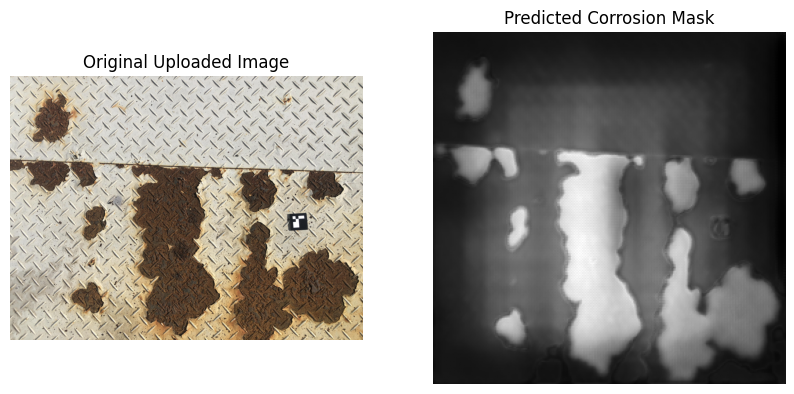

In [ ]:
from google.colab import files
#Upload your image
print("Please upload an image for corrosion detection.")
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
#Load and preprocess the image
image_pil = Image.open(img_path).convert('RGB')
image_np = np.array(image_pil)
enhanced_image_np = enhance(image_np)
enhanced_image_pil = Image.fromarray(enhanced_image_np)
# Define preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
input_tensor = transform(enhanced_image_pil).unsqueeze(0).to(device)

# Load trained model
model = UNet()
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
model.to(device)
model.eval()

#Run prediction
with torch.no_grad():
    pred_mask = model(input_tensor).squeeze().cpu().numpy()
#Display original and predicted mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_pil)
plt.title("Original Uploaded Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Corrosion Mask")
plt.axis('off')
plt.show()